# Boston House
## param : 162,869
## mean: 20.73%, std: 18.34%
## train - 14%
## 주의 : 재실행 시 결과 변함(learning rate 조절하는 비율 달라지는 경우)

In [1]:
#https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
# import the necessary packages
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import locale

In [3]:
## 그대로(파일 읽는 코드) ##
def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()

	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)

	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])

	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoing, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])

	# return the concatenated training and testing data
	return (trainX, testX)

#def load_house_images(df, inputPath):
def load_house_images(df, zf):
	# initialize our images array (i.e., the house images themselves)
	images = []
	#print(df.index.values)

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		#basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		basePath = "{}_".format(i + 1)
		#housePaths = sorted(list(glob.glob(basePath)))
		housePaths = sorted([ix for ix in zf.namelist() if ix.startswith(basePath)])
		#print(basePath, housePaths)

		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")

		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			#image = cv2.imread(housePath)
			#print(i, basePath, housePath)
			image = cv2.imdecode(np.frombuffer(zf.read(housePath), np.uint8), 1)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)

		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)

	# return our set of images
	return np.array(images)

In [4]:
## 수정(핵심) - 1 ##
# 입력 : trainAttrX.shape[1]
def create_mlp(dim, regress=False):
	#NK: <Option 1> You can change DNN model below
	# define our MLP network
	model = Sequential()
	model.add(Dense(32, input_dim=dim, activation="relu", kernel_initializer = 'he_normal'))
	model.add(Dense(16, activation="relu", kernel_initializer = 'he_normal'))
	model.add(Dense(8, activation="relu", kernel_initializer = 'he_normal'))
	model.add(Dense(4, activation="relu", kernel_initializer = 'he_normal'))
       
	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	# return our model
	return model

## 수정(핵심) - 2 ##
# 입력 : 이미지
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	#NK: <Option 2> You can change CNN model below
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
    # 64 x 64 x 3
	inputs = Input(shape=inputShape)
    # initializer
 
	# loop over the number of filters(16 -> 32 -> 64)
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

        # loop1 - 16 filter, 3x3, relu, BatchNorm, Maxpool
        # loop1 - 16 filter, 5x5, relu, batchNorm, Maxpool
        # loop2 - 32 filter, 3x3, relu, BatchNorm, Maxpool
        # loop2 - 32 filter, 5x5, relu, BatchNorm, Maxpool
        # loop3 - 64 filter, 3x3, relu, BatchNorm, Maxpool
        # loop3 - 64 filter, 5x5, relu, BatchNorm, Maxpool
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same", kernel_initializer = 'he_normal')(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(f, (5, 5), padding="same", kernel_initializer = 'he_normal')(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
# 		x = Conv2D(f, (5, 5), padding="same", kernel_initializer = 'he_normal')(x)
# 		x = Activation("relu")(x)
# 		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

    
    # after loop3, flatten()
    # dense16, relu, BatchNorm, Dropout
	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = GlobalAveragePooling2D()(x)
	x = Dense(32)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
# 	x = Dropout(0.7)(x)

    # cnn 마지막 - dense4, relu
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(16)(x)
	x = Activation("relu")(x)


	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [5]:
## 그대로 ##
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
#inputPath = os.path.sep.join(["Houses_Dataset", "HousesInfo.txt"])
import zipfile
zf = zipfile.ZipFile('D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/Houses_Dataset.zip')
inputfile = zf.open('HousesInfo.txt')
#df = load_house_attributes(inputPath)
df = load_house_attributes(inputfile)

[INFO] loading house attributes...


In [6]:
## 그대로 ##
# load the house images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading house images...")
#images = load_house_images(df, "Houses_Dataset")
images = load_house_images(df, zf)
images = images / 255.0

[INFO] loading house images...


In [7]:
## 그대로 ##
#NK: <Caveat> DO NOT CHANGE THIS PART, 25% OF DATA WILL BE USED AS TEST SET
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
# df와 images들을 train / test 용으로 split해준다.
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

[INFO] processing data...


In [8]:
# df = Houseinfo.txt 파일, 구성은 다음과 같음
# ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df.head(3)

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000


In [9]:
# trainAttrX : df를 일정 비율로 나눈 결과
trainAttrX.head(3)

,bedrooms,bathrooms,area,zipcode,price
148,5,3.5,4245,92677,1895000
337,2,2.0,1176,92276,135000
444,3,3.0,2800,93510,630000


In [10]:
## 그대로 ##
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [11]:
## 그대로 ##
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [12]:
# 값들 scale 조정
# zipcode : Encoding, ["bedrooms", "bathrooms", "area"]
print(trainAttrX) # (271 x 10)
print(trainAttrX.shape[0])
print(trainAttrX.shape[1])

[[0.         0.         1.         ... 0.44444444 0.45454545 0.56262899]
 [0.         1.         0.         ... 0.11111111 0.18181818 0.0754088 ]
 [0.         0.         0.         ... 0.22222222 0.36363636 0.3332275 ]
 ...
 [0.         1.         0.         ... 0.11111111 0.18181818 0.1020797 ]
 [0.         0.         0.         ... 0.22222222 0.18181818 0.22336879]
 [0.         0.         0.         ... 0.11111111 0.         0.06874107]]
271
10


In [13]:
## 수정 가능 - 3(수정 X, input 넣어주는 코드임) ##
#NK: <Option 3> You can change numbers of units in create_mlp and create_cnn functions
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

In [14]:
## 그대로 ##
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

In [15]:
## 수정 가능 - 4 ##
## 모델 마지막 dense4, dense1 ##
#NK: <Option 4> You can change numbers of FC (fully connected) layers
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [16]:
## 그대로 ##
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [17]:
## 수정 가능(opt) - 5 ##
#NK: <Option 5> You can change optimizer, loss and accuracy metric below
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [18]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          activation[0][0]                 
_______________________________________________________________________________________

In [19]:
## 수정 가능(batch_size만) - 6 ##
#NK: <Option 6> DO NOT CHANGE "validation_data"
#NK: You can change epochs and batch_size depending on performances of your models
#NK: Simple increase of epoch may not be so helpful
# train the model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
es = EarlyStopping(patience=30, verbose=1)
reLR = ReduceLROnPlateau(monitor = 'val_loss', patience=15, verbose=1, factor=0.5)
print("[INFO] training model...")
history = model.fit([trainAttrX, trainImagesX], trainY,validation_data=([testAttrX, testImagesX], testY),epochs=200, batch_size=8,verbose=1, callbacks=[es,reLR])

[INFO] training model...
Epoch 1/200
34/34 [==============================] - 1s 29ms/step - loss: 876.7513 - val_loss: 627.8524
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 399.8943 - val_loss: 259.6761
Epoch 3/200
34/34 [==============================] - 0s 11ms/step - loss: 285.0229 - val_loss: 1027.7794
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 239.2049 - val_loss: 187.5644
Epoch 5/200
34/34 [==============================] - 0s 10ms/step - loss: 234.0076 - val_loss: 290.2101
Epoch 6/200
34/34 [==============================] - 0s 10ms/step - loss: 212.1743 - val_loss: 220.0423
Epoch 7/200
34/34 [==============================] - 0s 10ms/step - loss: 189.6904 - val_loss: 156.8298
Epoch 8/200
34/34 [==============================] - 0s 10ms/step - loss: 171.0419 - val_loss: 128.2774
Epoch 9/200
34/34 [==============================] - 0s 10ms/step - loss: 130.9397 - val_loss: 169.0490
Epoch 10/200
34/34 [==================

31/34 [==========================>...] - ETA: 0s - loss: 17.1798
Epoch 00154: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
34/34 [==============================] - 0s 10ms/step - loss: 16.8276 - val_loss: 22.0776
Epoch 155/200
34/34 [==============================] - 0s 10ms/step - loss: 16.6936 - val_loss: 21.5640
Epoch 156/200
34/34 [==============================] - 0s 10ms/step - loss: 16.3684 - val_loss: 22.9652
Epoch 157/200
34/34 [==============================] - 0s 10ms/step - loss: 16.4125 - val_loss: 21.6916
Epoch 158/200
34/34 [==============================] - 0s 10ms/step - loss: 15.1951 - val_loss: 22.7402
Epoch 159/200
34/34 [==============================] - 0s 10ms/step - loss: 17.1483 - val_loss: 22.7816
Epoch 160/200
34/34 [==============================] - 0s 10ms/step - loss: 16.0104 - val_loss: 21.2888
Epoch 161/200
34/34 [==============================] - 0s 10ms/step - loss: 15.8274 - val_loss: 23.3972
Epoch 162/200
34/34 [=================

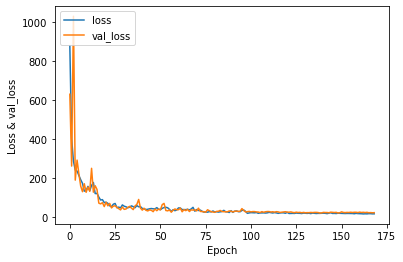

[14.584836959838867, 15.730515480041504, 15.660930633544922, 14.748885154724121, 14.809896469116211]
[22.545194625854492, 20.487775802612305, 21.114219665527344, 20.235736846923828, 20.73248863220215]


In [20]:
## 그대로 ##
#NK: <Option 7> The purpose is to minimize loss and val_loss of your models
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss & val_loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()
print(history.history['loss'][-5:])
print(history.history['val_loss'][-5:])

In [21]:
## 그대로 ##
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])

[INFO] predicting house prices...


In [22]:
## 그대로 ##
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [23]:
## 그대로 ##
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [24]:
## 그대로 ##
#NK: <Option 8> The purpose is to minimize the differences between predicted and real prices: minimize mean and std
#NK: <Caveat> High rate of differences in <08 keras-regression-cnns> compared with <02 keras-regression>
#NK: Overall performance depends on text data, but you can also make a good CNN model to make the differences smaller
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 20.73%, std: 18.34%
